<a href="https://colab.research.google.com/github/Rishad-A-Pulok/Sign_Language_BdSL_Word/blob/main/BdSL_Word_Final_DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.models import Sequential
from keras import backend as K
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.applications import resnet
from keras.applications.vgg16 import VGG16
from keras.models import Model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
!unzip "/content/drive/MyDrive/Sign Language Project/BdSL_Word.zip"

Archive:  /content/drive/MyDrive/Sign Language Project/BdSL_Word.zip
   creating: Word/
   creating: Word/Color/
  inflating: Word/Color/color (1).jpg  
  inflating: Word/Color/color (10).jpg  
  inflating: Word/Color/color (11).jpg  
  inflating: Word/Color/color (12).jpg  
  inflating: Word/Color/color (13).jpg  
  inflating: Word/Color/color (14).jpg  
  inflating: Word/Color/color (15).jpg  
  inflating: Word/Color/color (16).jpg  
  inflating: Word/Color/color (17).jpg  
  inflating: Word/Color/color (18).jpg  
  inflating: Word/Color/color (19).jpg  
  inflating: Word/Color/color (2).jpg  
  inflating: Word/Color/color (20).jpg  
  inflating: Word/Color/color (21).jpg  
  inflating: Word/Color/color (22).jpg  
  inflating: Word/Color/color (23).jpg  
  inflating: Word/Color/color (24).jpg  
  inflating: Word/Color/color (25).jpg  
  inflating: Word/Color/color (26).jpg  
  inflating: Word/Color/color (27).jpg  
  inflating: Word/Color/color (28).jpg  
  inflating: Word/Color/colo

In [4]:
base_path = '/content/Word'

In [5]:
SIZE = 224
image_size = (SIZE, SIZE)
batch_size = 32
channels = 3
kernel = 4
stride = 1
pool = 2

(224, 224, 3)


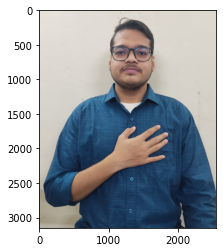

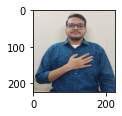

In [6]:
#show resized images
img = cv2.imread("/content/Word/Myself/myself (55).jpg")[:, :, ::-1]
width, height = SIZE, SIZE
resized_img = cv2.resize(img, (width, height))
plt.imshow(img)
plt.figure(figsize = (1.5, 1.5))
plt.imshow(resized_img)
print(resized_img.shape)

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    base_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = image_size,
    batch_size = batch_size,
)

Found 992 files belonging to 10 classes.
Using 794 files for training.
Found 992 files belonging to 10 classes.
Using 198 files for validation.


In [8]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    shear_range = 0.2,
    horizontal_flip= True,
    vertical_flip= False,
    validation_split= 0.2,
)
test_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split= 0.2,
)

In [9]:
train_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = True,
    subset = 'training'
)
test_set = train_datagen.flow_from_directory(
    base_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode= 'categorical',
    shuffle = False,
    subset = 'validation'
)

Found 796 images belonging to 10 classes.
Found 196 images belonging to 10 classes.


In [10]:
test_set.class_indices

{'Color': 0,
 'Friend': 1,
 'Myself': 2,
 'Promise': 3,
 'Request': 4,
 'Salam': 5,
 'Surprise': 6,
 'They': 7,
 'Think': 8,
 'You': 9}

In [11]:
class_names = train_ds.class_names
num_classes = len(class_names)
class_names

['Color',
 'Friend',
 'Myself',
 'Promise',
 'Request',
 'Salam',
 'Surprise',
 'They',
 'Think',
 'You']

In [12]:
labels = ['Color','Friend','Myself','Promise','Request','Salam','Surprise','They','Think','You']

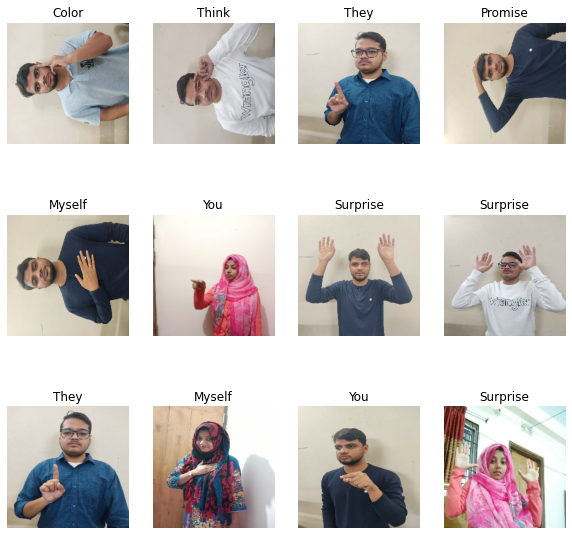

In [13]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in train_ds.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

#DenseNet201 Model

In [14]:
densenet = tf.keras.applications.densenet.DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))

74850304/74836368 [==============================] - 1s 0us/step


In [15]:
for layer in densenet.layers:
    layer.trainable = False

In [16]:
from tensorflow.keras import layers
standard_classifier = tf.keras.Sequential()
standard_classifier.add(layers.Flatten())
standard_classifier.add(layers.BatchNormalization())
standard_classifier.add(layers.Dense(100))
standard_classifier.add(layers.Activation('relu'))
standard_classifier.add(layers.Dense(10))
standard_classifier.add(layers.Activation('softmax'))

In [17]:
model = tf.keras.Sequential([
  densenet,
  standard_classifier
])

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 sequential (Sequential)     (None, 10)                9785430   
                                                                 
Total params: 28,107,414
Trainable params: 9,597,270
Non-trainable params: 18,510,144
_________________________________________________________________


In [20]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 42.6 MB/s 


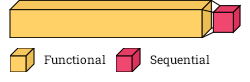

In [21]:
from PIL import ImageFont
import visualkeras
font = ImageFont.truetype("/content/drive/MyDrive/Sign Language Project/RobotoSlab-VariableFont_wght.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font)

In [22]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoint.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [23]:
history = model.fit(
  train_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(train_set),
  validation_steps=len(test_set),
  callbacks=model_checkpoint,
)

Epoch 1/25
25/25 [==============================] - 167s 6s/step - loss: 3.6636 - accuracy: 0.6784 - val_loss: 9.0293 - val_accuracy: 0.6684
Epoch 2/25
25/25 [==============================] - 127s 5s/step - loss: 1.3416 - accuracy: 0.9058 - val_loss: 2.9085 - val_accuracy: 0.7653
Epoch 3/25
25/25 [==============================] - 128s 5s/step - loss: 0.6300 - accuracy: 0.9422 - val_loss: 2.0853 - val_accuracy: 0.8520
Epoch 4/25
25/25 [==============================] - 125s 5s/step - loss: 0.4190 - accuracy: 0.9560 - val_loss: 1.3666 - val_accuracy: 0.8980
Epoch 5/25
25/25 [==============================] - 125s 5s/step - loss: 0.2064 - accuracy: 0.9786 - val_loss: 2.2440 - val_accuracy: 0.8418
Epoch 6/25
25/25 [==============================] - 124s 5s/step - loss: 0.3594 - accuracy: 0.9749 - val_loss: 2.1340 - val_accuracy: 0.8673
Epoch 7/25
25/25 [==============================] - 125s 5s/step - loss: 0.2841 - accuracy: 0.9774 - val_loss: 1.3434 - val_accuracy: 0.9133
Epoch 8/25
25

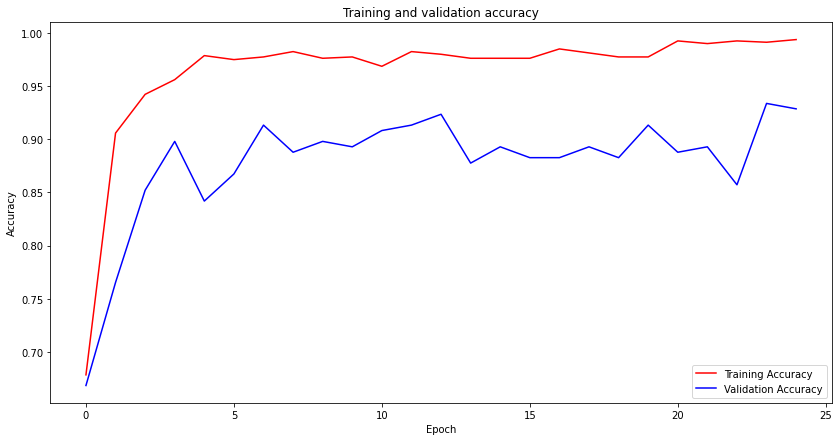

In [24]:
# Validation and Training accuracy plot
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

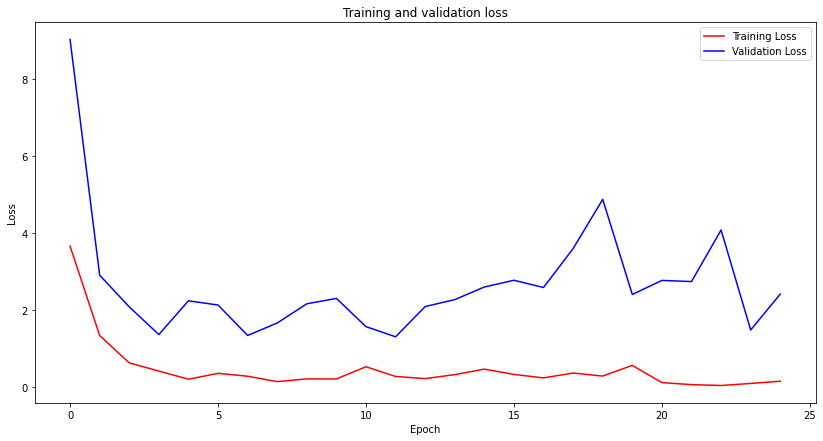

In [25]:
#Validation and Training loss plot
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [26]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

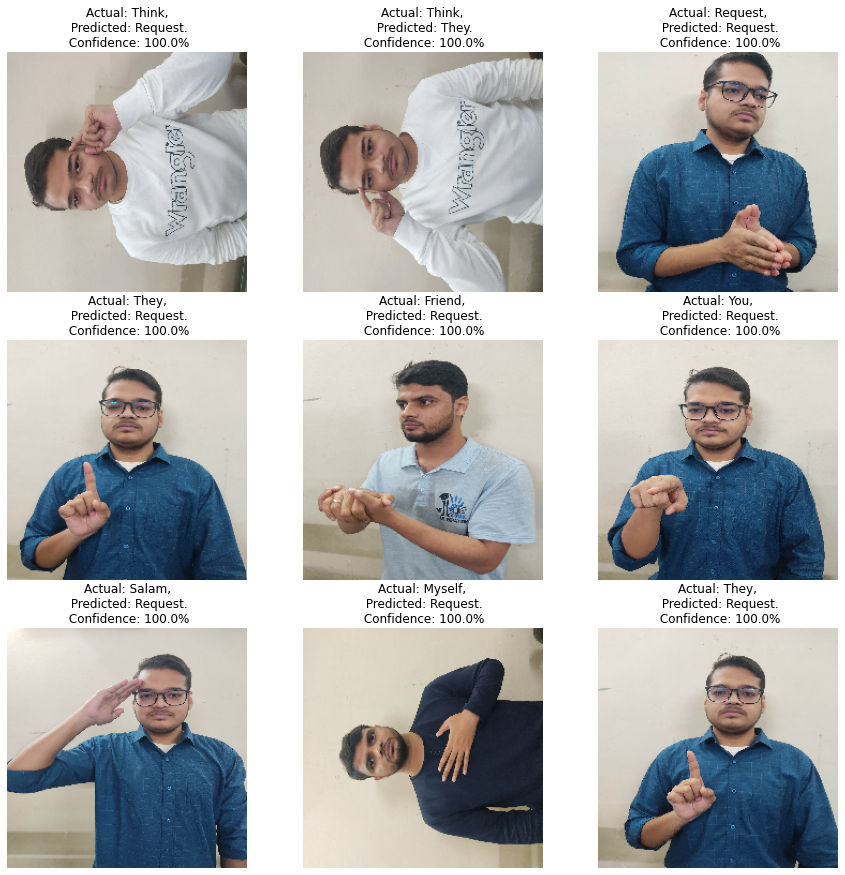

In [27]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        predicted_class, confidence =predict(model, image_batch[i].numpy())
        actual_class = class_names[labels_batch[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [28]:
loss,test_accuracy = model.evaluate(test_set)
print('Accuracy on test:', test_accuracy)

7/7 [==============================] - 28s 4s/step - loss: 3.0532 - accuracy: 0.9337
Accuracy on test: 0.9336734414100647


In [31]:
# T0 print the Classification Report
y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_set.classes, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       0.95      1.00      0.98        20
           2       0.95      0.95      0.95        21
           3       0.90      1.00      0.95        18
           4       0.79      0.90      0.84        21
           5       1.00      0.95      0.97        19
           6       1.00      1.00      1.00        20
           7       0.89      0.84      0.86        19
           8       1.00      0.95      0.98        21
           9       0.93      0.74      0.82        19

    accuracy                           0.93       196
   macro avg       0.94      0.93      0.93       196
weighted avg       0.94      0.93      0.93       196



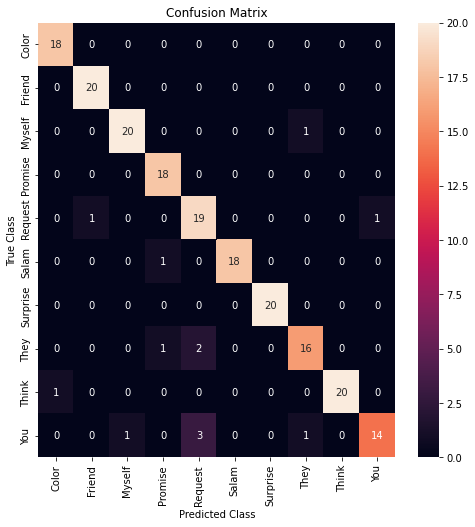

In [32]:
import seaborn as sns
# To print the Confusion Matrix
cf_matrix = confusion_matrix(test_set.classes, y_pred)
labels = ['Color','Friend','Myself','Promise','Request','Salam','Surprise','They','Think','You']
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(cf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()